<a href="https://colab.research.google.com/github/HC-JEONG/Introduction_to_Machine_Learning_with_Python/blob/master/Chapter_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 6 알고리즘 체인과 파이프라인

In [0]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm
from matplotlib import rc
%matplotlib inline
import pandas as pd
!pip install mglearn
import mglearn
import scipy as sp
import sklearn
import graphviz

#한글, 마이너스 기호 폰트 관련
print(mpl.__version__)
print(mpl.__file__)
print(mpl.get_configdir())
print(mpl.get_cachedir())

#나눔 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
sys_font=fm.findSystemFonts()
nanum_font = [f for f in sys_font if 'Nanum' in f]
# 한번 프린트 해보자
nanum_font
path = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
font_name = fm.FontProperties(fname=path, size=12).get_name()
plt.rc('font', family=font_name)
# 우선 fm._rebuild() 를 해주고
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 기호 오류 해결

3.0.3
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py
/root/.config/matplotlib
/root/.cache/matplotlib


In [0]:
# 데이터를 분할하고 최솟값, 최댓값을 찾아 데이터의 스케일을 바꾸고 SVM을 훈련시키는 코드
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# 훈련 데이터의 최솟값, 최댓값을 계산합니다.
scaler = MinMaxScaler().fit(X_train)

In [0]:
# 훈련 데이터의 스케일을 조정합니다.
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 스케일 조정된 훈련데이터에 SVM을 학습시킵니다.
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다.
X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.95


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# 6.1 데이터 전처리와 매개변수 선택

In [0]:
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요.
param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


> 위 코드는 문제가 있다. 데이터의 최솟값과 최댓값을 계산할 때 모든 데이터를 사용했다. 데이터의 어떤 부분은 training data가 되고 어떤 부분은 validation data가 될텐데 데이터 스케일을 조정할 때 validation data에 들어있는 정보까지 사용한 것이다.

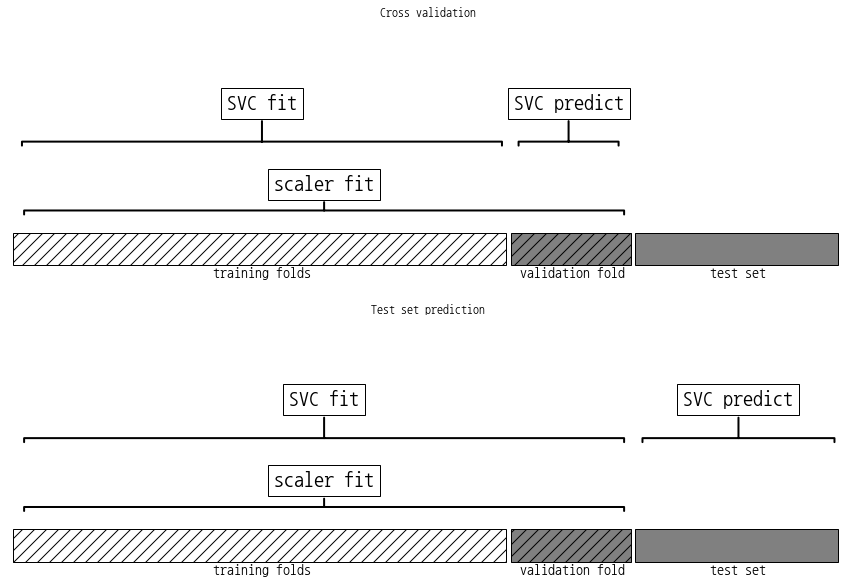

In [0]:
mglearn.plots.plot_improper_processing()

> 교차 검증의 분할이 모든 전처리 과정보다 앞서 이뤄져야 한다.

> cross_val_score와 GridSearchCV를 이런 방식으로 구현하려면 Pipeline을 사용하면 된다.

# 6.2 파이프라인 구축하기

In [0]:
# MinMaxScaler로 데이터의 스케일을 조정하고 SVM 모델을 훈련시키는 워크플로(workflow)를 Pipeline을 사용해 표현하기
# 각 단계를 리스트로 전달하여 파이프라인 객체를 만든다.

from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
# scaler라는 MinMaxScaler의 객체, svm이라는 SVC의 객체

In [0]:
# 파이프라인 fit 매서드 호출
pipe.fit(X_train, y_train)
# scaler의 fit 메서드를 호출해 훈련 데이터를 변환하고, 변환된 데이터에 svm 모델을 훈련시킨다.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [0]:
print("테스트 점수: {:.2f}".format(pipe.score(X_test, y_test)))
# score 메서드를 호출하면 scaler로 테스트 데이터를 변환하고 변환된 데이터에 svm 모델의 score 메서드를 호출

테스트 점수: 0.95


# 6.2 그리드 서치에 파이프라인 적용하기

> 각 매개변수가 파이프라인의 어떤 단계에 속한 것인지 알려줘야 한다.

> 파이프라인용 매개변수 그리드는 단계 이름과 매개변수 이름을 "__"로 연결해 만든다.

In [0]:
param_grid = {'svm__C' : [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}

In [0]:
grid = GridSearchCV(pipe, param_grid = param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수:", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


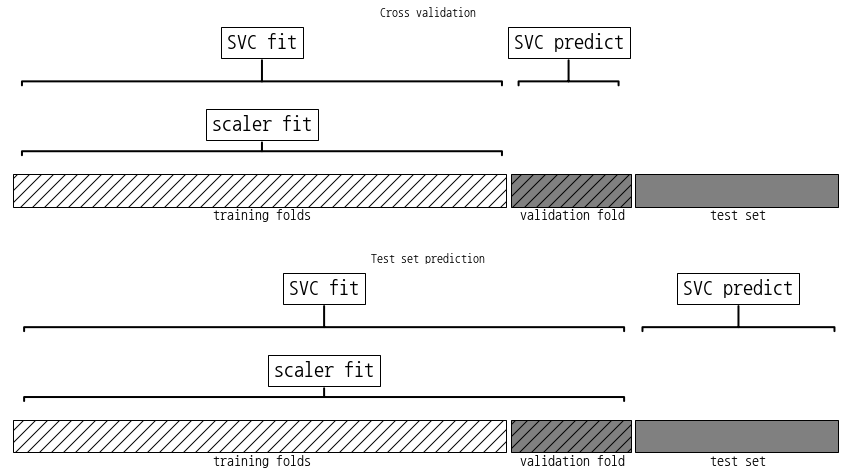

In [0]:
mglearn.plots.plot_proper_processing()

> validation data를 사용해 데이터의 스케일을 조정하는 경우엔 심각한 문제가 생기지 않지만, 검증 폴드를 이용해 특성을 추출하거나 선택하면 결과가 확연히 달라진다.

## 정보 누설에 대한 예시

In [0]:
# 정규분포로부터 독립적으로 추출한 10,000개의 특성을 가진 샘플 100개를 사용한 회귀 문제, 출력값도 정규분포로부터 샘플링.
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [0]:
# SelectPercentile로 10,000개 중 가장 유용한 특성을 선택
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape:", X_selected.shape)

X_selected.shape: (100, 500)


In [0]:
# 교차 검증을 사용하여 Ridge 회귀 평가
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("교차 검증 점수(리지): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 점수(리지): 0.91


In [0]:
# 파이프라인을 사용한 교차 검증과 비교
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("교차 검증 점수(파이프라인): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

# 파이프라인을 사용하면 테스트 데이터에서만 특성이 선택되기 때문에 점수가 낮다.

교차 검증 점수(파이프라인): -0.25


# 6.4 파이프라인 인터페이스

> 특성 추출, 특성 선택, 스케일 변경,  분류(회귀나 군집) 총 네 단계를 포함하는 파이프라인을 만들 수 있다.

> 파이프라인의 추정기는 마지막 단계를 제외하고 모두 transform 메서드를 가지고 있어야 한다.

> Pipeline.fit 메서드가 실행되는 동안 각 단계에서 이전 단계의 transform의 출력을 입력으로 받아 fit과 transform 메서드를 차례로 호출한다.

In [0]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다.
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출합니다.
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [0]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다.
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict를 호출합니다.
    return self.steps[-1][1].predict(X_transformed)

## 6.4.1 make_pipleline을 사용한 파이프라인 생성

In [0]:
from sklearn.pipeline import make_pipeline
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [0]:
print("파이프라인 단계:\n", pipe_short.steps)

파이프라인 단계:
 [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라인 단계:\n", pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


## 6.4.2 단계 속성에 접근하기

In [0]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용합니다.
pipe.fit(cancer.data)
# "pca" 단계의 두 개 주성분을 추출합니다.
components = pipe.named_steps["pca"].components_
print("components.shape:", components.shape)

components.shape: (2, 30)


## 6.4.3 그리드 서치 안의 파이프라인 속성에 접근하기

In [0]:
# StandardScaler와 LogisticRegression 분류기로 Pipeline을 만들어 cacner 데이터 셋에 그리드 서치 적용
# 먼저 make_pipeline으로 파이프라인 만들기
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [0]:
# 매개변수 그리드
param_grid = {'logisticregression__C' : [0.01, 0.1, 1, 10, 100]}

In [0]:
# cancer 데이터를 훈련/테스트 세트로 나누고 그리드 서치 적용
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                     

In [0]:
print("최상의 모델:\n", grid.best_estimator_)

최상의 모델:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [0]:
print("로지스틱 회귀 단계:\n",
      grid.best_estimator_.named_steps["logisticregression"])

로지스틱 회귀 단계:
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [0]:
print("로지스틱 회귀 계수:\n",
      grid.best_estimator_.named_steps["logisticregression"].coef_)

로지스틱 회귀 계수:
 [[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


# 6.5 전처리와 모델의 매개변수를 위한 그리드 서치

> 파이프라인을 사용하면

> 머신러닝 워크플로에 필요한 모든 처리 단계를 하나의 scikit-learn 추정기로 캡슐화 할 수 있다.

> 회귀와 분류 같은 지도 학습의 출력을 이용해서 전처리 매개변수를 조정할 수 있다.

In [0]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [0]:
param_grid = {'polynomialfeatures__degree': [1,2,3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [0]:
grid = GridSearchCV(pipe, param_grid = param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
         

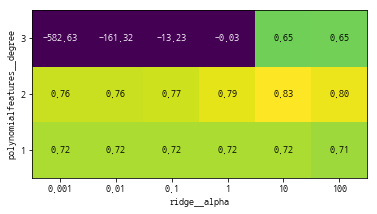

In [0]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3,-1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                     xticklabels=param_grid['ridge__alpha'],
                     yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [0]:
print("최적의 매개변수:", grid.best_params_)

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [0]:
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))


테스트 세트 점수: 0.77


In [0]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# 6.6 모델 선택을 위한 그리드 서치

In [0]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [0]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma' : [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier' : [RandomForestClassifier(n_estimators=100)],
    'preprocessing' : [None], 'classifier__max_features': [1,2,3]}]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


## 6.6.1 중복 계산 피하기

In [0]:
pipe =Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
               memory="cache_folder")

# 6.7 요약 및 정리

> 실제 머신러닝 어플리케이션에서는 모델을 단독으로 사용하는 경우가 거의 없고, 여러 처리 단계가 연속해서 이뤄진다.

> 파이프라인은 여러 단계를 하나의 파이썬 객체로 캡슐화해주고 fit, predict, transform 인터페이스를 사용할 수 있다.

> 교차 검증을 사용하여 모델을 평가하고 그리드 서치를 사용하여 매개변수 선택을 할 때 모든 처리 단계를 Pipeline으로 묶는 것은 올바른 평가를 위해 필수적이다.
